# Ejercicio 4

In [ ]:
import numpy as np

def generar_histograma_gradientes(magnitudes, orientaciones, num_bins=9, epsilon=1e-6):
    """
    Calcula histogramas normalizados de gradientes por bloque.
    """

    M, N, H, W = magnitudes.shape
    assert orientaciones.shape == (M, N, H, W), "orientaciones debe tener misma forma que magnitudes"

    ancho_bin = 180.0 / num_bins
    centros_bins = np.array([(i + 0.5) * ancho_bin for i in range(num_bins)], dtype=np.float32)

    resultado = np.zeros((M * N, num_bins), dtype=np.float32)

    bloque_idx = 0
    for i in range(M):
        for j in range(N):
            hist = np.zeros(num_bins, dtype=np.float32)

            for x in range(H):
                for y in range(W):
                    mag = magnitudes[i, j, x, y]
                    ang = orientaciones[i, j, x, y] % 180.0

                    pos = np.searchsorted(centros_bins, ang)

                    if pos == 0:
                        b1, b2 = 0, 1
                    elif pos >= num_bins:
                        b1 = b2 = num_bins - 1
                    else:
                        b1, b2 = pos - 1, pos

                    c1, c2 = centros_bins[b1], centros_bins[b2]

                    peso1 = abs(c2 - ang) / ancho_bin
                    peso2 = abs(ang - c1) / ancho_bin

                    total = peso1 + peso2
                    if total > 0:
                        peso1 /= total
                        peso2 /= total
                    else:
                        peso1, peso2 = 0.0, 1.0

                    hist[b1] += peso1 * mag
                    if b2 != b1:
                        hist[b2] += peso2 * mag

            norm = np.sqrt(np.sum(hist ** 2) + epsilon)
            hist /= norm

            resultado[bloque_idx] = hist
            bloque_idx += 1

    return resultado


## PRUEBA 1: Bloque con orientación constante

Histograma: [1. 0. 0. 0. 0. 0. 0. 0. 0.]


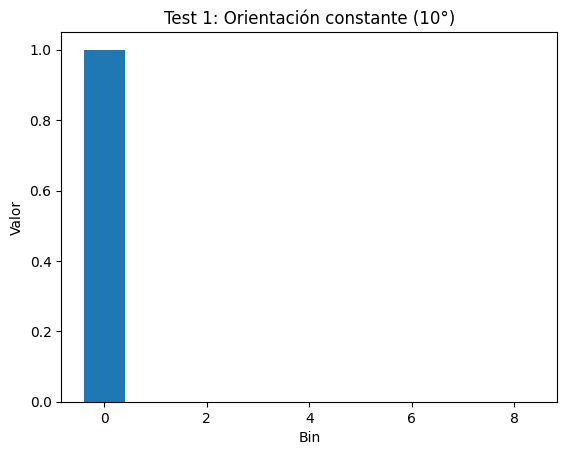

In [4]:
import numpy as np
import matplotlib.pyplot as plt

mu = np.ones((1, 1, 2, 2), dtype=np.float32)  # magnitud constante
theta = np.full((1, 1, 2, 2), 10.0, dtype=np.float32)  # todo con orientación de 10°

H = generar_histograma_gradientes(mu, theta, num_bins=9)

print("Histograma:", H[0])

plt.bar(range(9), H[0])
plt.title("Test 1: Orientación constante (10°)")
plt.xlabel("Bin")
plt.ylabel("Valor")
plt.show()


Como todos los píxeles están orientados a 10°, que cae justo en el centro del primer bin, el histograma acumula todos los votos ahí. Como las magnitudes son iguales, el valor total es uniforme y luego normalizado.

## PRUEBA 2: Orientaciones a mitad de dos bins (interpolación bilineal)

Histograma: [0.7071067 0.7071067 0.        0.        0.        0.        0.
 0.        0.       ]


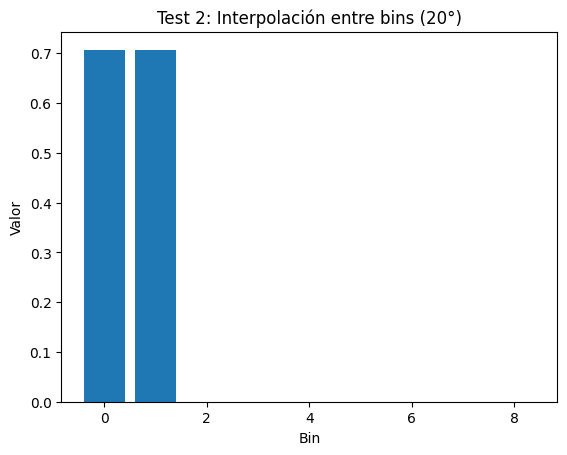

In [5]:
mu = np.ones((1, 1, 2, 2), dtype=np.float32)
theta = np.full((1, 1, 2, 2), 20.0, dtype=np.float32)  # entre bin 1 y 2 (centros: 10° y 30°)

H = generar_histograma_gradientes(mu, theta, num_bins=9)

print("Histograma:", H[0])

plt.bar(range(9), H[0])
plt.title("Test 2: Interpolación entre bins (20°)")
plt.xlabel("Bin")
plt.ylabel("Valor")
plt.show()


Como 20° cae exactamente entre los centros de los bins 1 (10°) y 2 (30°), los votos se reparten 50% a cada uno, gracias a la interpolación bilineal.

##  PRUEBA 3: Ángulos al límite del rango (cerca de 0° y 180°)

Histograma: [0.8096263  0.25126332 0.         0.         0.         0.
 0.         0.         0.5304448 ]


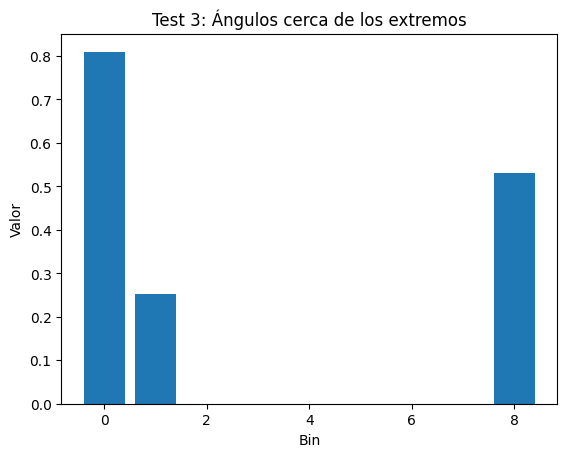

In [6]:
theta = np.array([[[[179.0, 1.0],
                    [179.0, 1.0]]]], dtype=np.float32)
mu = np.ones((1, 1, 2, 2), dtype=np.float32)

H = generar_histograma_gradientes(mu, theta, num_bins=9)

print("Histograma:", H[0])

plt.bar(range(9), H[0])
plt.title("Test 3: Ángulos cerca de los extremos")
plt.xlabel("Bin")
plt.ylabel("Valor")
plt.show()


Esto prueba que el módulo 180° está funcionando. Aunque 179° está muy cerca de 0°, cae en el último bin (170°) y 1° en el primero (10°), sin errores.

## PRUEBA 4: Magnitudes distintas

Histograma: [1. 0. 0. 0. 0. 0. 0. 0. 0.]


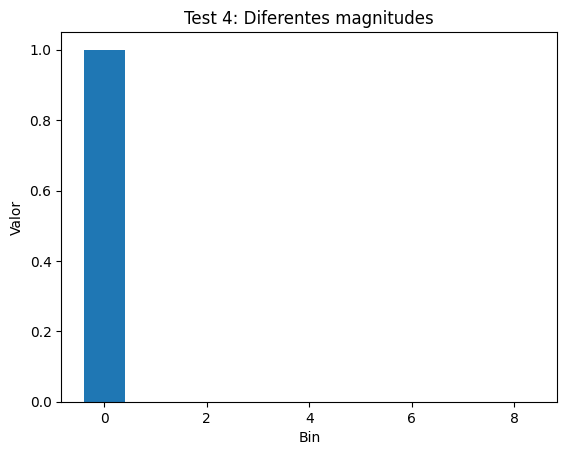

In [7]:
mu = np.array([[[[1, 2],
                 [3, 4]]]], dtype=np.float32)
theta = np.full((1, 1, 2, 2), 10.0, dtype=np.float32)

H = generar_histograma_gradientes(mu, theta, num_bins=9)

print("Histograma:", H[0])

plt.bar(range(9), H[0])
plt.title("Test 4: Diferentes magnitudes")
plt.xlabel("Bin")
plt.ylabel("Valor")
plt.show()


Como todas las orientaciones son iguales, el histograma se acumula en un solo bin, pero el peso ahora depende de la magnitud. Después se normaliza con norma L2, así que se ve la distribución proporcional.

## PRUEBA 5: Todo ceros

Histograma: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


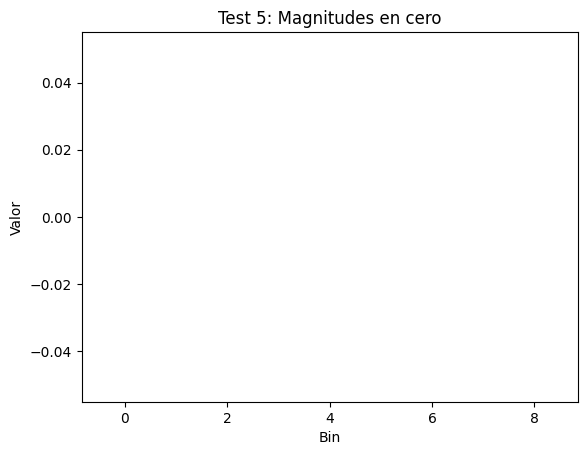

In [8]:
mu = np.zeros((1, 1, 2, 2), dtype=np.float32)
theta = np.zeros((1, 1, 2, 2), dtype=np.float32)

H = generar_histograma_gradientes(mu, theta, num_bins=9)

print("Histograma:", H[0])

plt.bar(range(9), H[0])
plt.title("Test 5: Magnitudes en cero")
plt.xlabel("Bin")
plt.ylabel("Valor")
plt.show()


Al no haber magnitudes (todo es cero), no se vota nada a ningún bin, y el histograma queda completamente vacío. Esto también sirve para probar que no hay errores al dividir por cero.